# Loading the data bundle

In [ ]:
import os
import zipline
from zipline.data import bundles
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.utils.calendars import get_calendar
from zipline.pipeline.data import USEquityPricing
from zipline.data.data_portal import DataPortal
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.domain import US_EQUITIES
from zipline.pipeline.factors import AverageDollarVolume
from zipline.pipeline import Pipeline
import pandas as pd

from datetime import timedelta

bundle_name = 'alpaca_api'
bundle_data = bundles.load(bundle_name)

# set the dataloader
pricing_loader = USEquityPricingLoader.without_fx(bundle_data.equity_daily_bar_reader, 
                                                  bundle_data.adjustment_reader)

# define the function for the get_loader parameter
def choose_loader(column):
    if column not in USEquityPricing.columns:
        raise Exception('Column not in USEquityPricing')
    return pricing_loader

# set the trading calender
trading_calender = get_calendar('NYSE')

start_date = pd.Timestamp('2015-12-31', tz='utc')
pipeline_start_date = start_date + timedelta(days=365*2 + 10)
end_date = pd.Timestamp('2021-11-28', tz='utc')

# create a data portal
data_portal = DataPortal(bundle_data.asset_finder,
                         trading_calendar=trading_calender,
                         first_trading_day=start_date,
                         equity_daily_reader=bundle_data.equity_daily_bar_reader,
                         adjustment_reader=bundle_data.adjustment_reader)

# create a pipeline engine
engine = SimplePipelineEngine(get_loader=choose_loader,
                              asset_finder=bundle_data.asset_finder)

# create a screen for pipeline
universe = AverageDollarVolume(window_length=5).top(10)

# create an empty pipeline with the given screen
pipeline = Pipeline(screen=universe, domain=US_EQUITIES)
pipeline.add(AverageDollarVolume(window_length=5), "Dollar Volume")

# Run pipeline for the given start and end dates
pipeline_output = engine.run_pipeline(pipeline, start_date, end_date)

pipeline_output.head()

In [ ]:
import os
import pandas as pd
from datetime import timedelta

import zipline
from zipline.data import bundles
from zipline.utils.calendars import get_calendar
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.classifiers.custom.sector import ZiplineTraderSector, SECTOR_LABELS
from zipline.pipeline.factors import CustomFactor, Returns, AverageDollarVolume
from zipline.pipeline.domain import US_EQUITIES
from zipline.research.utils import get_pricing, create_data_portal, create_pipeline_engine

class YearlyReturns(CustomFactor):
    inputs = [USEquityPricing.close]
    window_length = 252
    def compute(self, today, assets, out, prices):
        start = self.window_length
        out[:] = (prices[-1] - prices[-start])/prices[-start]

universe = AverageDollarVolume(window_length=5)
trader_calendar = get_calendar('NYSE')
bundle_name = 'alpaca_api'
start_date = pd.Timestamp('2018-12-28', tz='utc')
pipeline_start_date = start_date + timedelta(days=365 + 10)
end_date = pd.Timestamp('2020-12-28', tz='utc')
data_portal = create_data_portal(bundle_name, trader_calendar, start_date)
engine = create_pipeline_engine(bundle_name)
pipeline = Pipeline(
    columns = {
        #'MyFactor': YearlyReturns(),
        'Return': Returns(window_length=252),
        'Sector': ZiplineTraderSector()
    }, domain=US_EQUITIES
)

In [ ]:
factors = engine.run_pipeline(pipeline, pipeline_start_date, end_date)
factors.head()

In [ ]:
asset_list = factors.index.levels[1].unique()

prices = get_pricing(data_portal, trader_calendar, asset_list,
                     pipeline_start_date, end_date)

prices.head()

In [ ]:
import alphalens as al
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=factors['Return'],
    prices=prices,
    quantiles=5,
    periods=[1, 5, 10],
    groupby=factors['Sector'],
    binning_by_group=True,
    groupby_labels=SECTOR_LABELS,
    max_loss=0.4)

In [ ]:
factor_data.head(10)

In [ ]:
al.tears.create_full_tear_sheet(factor_data, long_short=True, group_neutral=False, by_group=True)

# Backtesting

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

import zipline
from zipline.data import bundles
bundle_name = 'alpaca_api'
bundle_data = bundles.load(bundle_name)
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.utils.calendars import get_calendar
from zipline.pipeline.data import USEquityPricing
from zipline.data.data_portal import DataPortal

import pandas as pd

In [ ]:
# set the dataloader
pricing_loader = USEquityPricingLoader.without_fx(bundle_data.equity_daily_bar_reader, 
                                                  bundle_data.adjustment_reader)

# define the function for the get_loader parameter
def choose_loader(column):
    if column not in USEquityPricing.column:
        raise Exception('Column not in USEquityPricing')
    return pricing_loader

# set the trading calendar
trading_calendar = get_calendar('NYSE')

start_date = pd.Timestamp('2019-07-05', tz='utc')
end_data = pd.Timestamp('2020-11-13', tz='utc')

# create a data portal
data_portal = DataPortal(bundle_data.asset_finder,
                         trading_calendar=trading_calendar,
                         first_trading_day=start_date,
                         equity_daily_reader=bundle_data.equity_daily_bar_reader,
                         adjustment_reader=bundle_data.adjustment_reader)


In [ ]:
import dateutil.parser
from os.path import join, exists
import pandas_datareader.data as yahoo_reader
import yaml
import numpy as np

def get_benchmark(symbol=None, start=None, end=None, other_file_path=None):
    bm = yahoo_reader.DataReader(symbol,
                                 'yahoo',
                                 pd.Timestamp(start),
                                 pd.Timestamp(end))['Close']
    bm.index = bm.index.tz_localize('UTC')
    return bm.pct_change(periods=1).fillna(0)

In [ ]:
from zipline.api import order_target, record, symbol
import matplotlib.pyplot as plt

def initialize(context):
    context.equity = bundle_data.asset_finder.lookup_symbol('AMZN', end_data)

def handle_data(context, data):
    order_target(context.equity, 100)
    
def before_trading_start(context, data):
    pass

def analyze(context, perf):
    ax1 = plt.subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax2 = plt.subplot(212, sharex=ax1)
    pert.sym.plot(ax=ax2, color='r')
    plt.gcf().set_size_inches(18, 8)
    plt.legend(['Algo', 'Benchmark'])
    plt.ylabel("Returns", color='black', size=25)


In [ ]:
from datetime import datetime
import pytz

from zipline import run_algorithm


start_date = pd.Timestamp(datetime(2020, 1, 1, tzinfo=pytz.UTC))
end_date = pd.Timestamp(datetime(2020, 11, 1, tzinfo=pytz.UTC))

r = run_algorithm(start=start_date,
                  end=end_data,
                  initialize=initialize,
                  capital_base=10000,
                  handle_data=handle_data,
                  benchmark_returns=get_benchmark(symbol="SPY",
                                                  start=start_date.date().isoformat(),
                                                  end=end_data.date().isoformat()),
                  bundle='alpaca_api',
                  broker=None,
                  state_filename='./demo.state',
                  trading_calendar=trading_calendar,
                  before_trading_start=before_trading_start,
                  data_frequency='daily')
fig, axes = plt.subplots(1, 1, figsize=(16, 5), sharex=True)
r.algorithm_period_return.plot(color='blue')
r.benchmark_period_return.plot(color='red')

plt.legend(['Algo', 'Benchmark'])
plt.ylabel("Returns", color='black', size=20)

In [ ]:
import pyfolio as pf
import empyrical
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(r)
benchmark_returns = r.benchmark_period_return

print("returns sharp ratio: {}".format(empyrical.sharpe_ratio(returns)))
print("benchmark sharp ratio: {}".format(empyrical.sharpe_ratio(benchmark_returns)))
print("beta ratio: {}".format(empyrical.beta(returns, benchmark_returns)))
print("alpha ratio: {}".format(empyrical.alpha(returns, benchmark_returns)))

In [ ]:
pf.create_position_tear_sheet(returns, 
                              positions=positions, 
                              transactions=transactions)

In [ ]:
pf.create_full_tear_sheet(returns,
                             positions=positions,
                             transactions=transactions,
                             benchmark_rets=benchmark_returns)

# alphalens 
https://github.com/quantopian/alphalens/blob/master/alphalens/examples/tear_sheet_walk_through.ipynb

In [3]:
%pylab inline --no-import-all
import alphalens
import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
ticker_sector = {"AAPL":0,"ABBV":2,"ABT":2,"ACN":0,"ADBE":0,"AIG":1,"AMGN":2,
                 "AMT":5,"AMZN":9,"AVGO":0,"AXP":1,"BA":3,"BAC":1,"BIIB":2,"BK":1,
                 "BKNG":9,"BLK":1,"BMY":2,"BRK-B":1,"C":1,"CAT":3,"CHTR":7,"CL":8,
                 "CMCSA":7,"COF":1,"COP":10,"COST":8,"CRM":0,"CSCO":0,"CVS":2,"CVX":10,
                 "DD":6,"DHR":2,"DIS":7,"DOW":6,"DUK":4,"EMR":3,"EXC":4,"F":9,"FB":7,
                 "FDX":3,"GD":3,"GE":3,"GILD":2,"GM":9,"GOOG":7,"GOOGL":7,"GS":1,"HD":9,
                 "HON":3,"IBM":0,"INTC":0,"JNJ":2,"JPM":1,"KHC":8,"KO":8,"LIN":3,"LLY":2,
                 "LMT":3,"LOW":9,"MA":1,"MCD":9,"MDLZ":8,"MDT":2,"MET":1,"MMM":3,"MO":8,
                 "MRK":2,"MS":1,"MSFT":0,"NEE":4,"NFLX":7,"NKE":9,"NVDA":0,"ORCL":0,"PEP":8,
                 "PFE":2,"PG":8,"PM":8,"PYPL":1,"QCOM":0,"RTX":3,"SBUX":9,"SO":4,"SPG":5,"T":7,
                 "TGT":8,"TMO":2,"TMUS":7,"TSLA":9,"TXN":0,"UNH":2,"UNP":3,"UPS":3,"USB":1,
                 "V":1,"VZ":7,"WBA":8,"WFC":1,"WMT":8,"XOM":10}

sector_names = {
    0 : "information_technology",
    1 : "financials",
    2 : "health_care",
    3 : "industrials",
    4 : "utilities", 
    5 : "real_estate", 
    6 : "materials", 
    7 : "telecommunication_services", 
    8 : "consumer_staples", 
    9 : "consumer_discretionary", 
    10 : "energy" 
}

In [6]:
import pandas_datareader.data as web
pan = web.DataReader(list(ticker_sector.keys()), "yahoo", '2021-01-01', '2022-01-01')

In [7]:
pan.columns.levels

FrozenList([['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], ['AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'AMGN', 'AMT', 'AMZN', 'AVGO', 'AXP', 'BA', 'BAC', 'BIIB', 'BK', 'BKNG', 'BLK', 'BMY', 'BRK-B', 'C', 'CAT', 'CHTR', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'DD', 'DHR', 'DIS', 'DOW', 'DUK', 'EMR', 'EXC', 'F', 'FB', 'FDX', 'GD', 'GE', 'GILD', 'GM', 'GOOG', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KHC', 'KO', 'LIN', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDLZ', 'MDT', 'MET', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NEE', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'RTX', 'SBUX', 'SO', 'SPG', 'T', 'TGT', 'TMO', 'TMUS', 'TSLA', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'V', 'VZ', 'WBA', 'WFC', 'WMT', ...]])

In [ ]:
pan.T.loc['Open']

In [8]:
lookahead_bias_days = 5


predictive_factor = pan.T.loc['Open'].T
predictive_factor = predictive_factor.pct_change(lookahead_bias_days)

In [9]:
predictive_factor.shift(-lookahead_bias_days)
predictive_factor = predictive_factor.stack()
predictive_factor.index = predictive_factor.index.set_names(['date', 'asset'])

In [ ]:
predictive_factor.head()

In [10]:
pricing = pan.T.loc['Open'].T.iloc[1:]
pricing.head()

Symbols           AAPL        ABBV         ABT         ACN        ADBE  \
Date                                                                     
2021-01-05  128.889999  105.410004  108.849998  256.399994  485.880005   
2021-01-06  127.720001  104.750000  108.949997  259.200012  474.100006   
2021-01-07  128.360001  106.110001  110.279999  260.359985  471.000000   
2021-01-08  132.429993  106.839996  111.669998  263.809998  480.000000   
2021-01-11  129.190002  107.070000  111.209999  262.829987  481.989990   

Symbols           AIG        AMGN         AMT        AMZN        AVGO  ...  \
Date                                                                   ...   
2021-01-05  37.279999  226.940002  220.119995  3166.01001  425.049988  ...   
2021-01-06  38.619999  225.000000  219.500000  3146.47998  423.299988  ...   
2021-01-07  40.779999  231.860001  215.270004  3157.00000  432.059998  ...   
2021-01-08  41.000000  235.529999  218.240005  3180.00000  447.000000  ...   
2021-01-11  39.919998  240.000000  221.259995  3148.01001  440.609985  ...   

Symbols            UNH         UNP         UPS        USB           V  \
Date                                                                    
2021-01-05  348.690002  202.899994  162.679993  46.110001  216.309998   
2021-01-06  337.109985  205.550003  160.279999  47.529999  213.800003   
2021-01-07  358.540009  210.610001  161.619995  49.650002  212.199997   
2021-01-08  367.000000  218.000000  159.110001  50.040001  214.169998   
2021-01-11  362.619995  220.179993  158.869995  48.790001  213.960007   

Symbols            VZ        WBA        WFC         WMT        XOM  
Date                                                                
2021-01-05  58.860001  41.500000  30.090000  146.600006  41.840000  
2021-01-06  58.810001  42.209999  31.900000  145.089996  44.410000  
2021-01-07  58.270000  44.040001  33.580002  147.619995  45.000000  
2021-01-08  58.230000  45.049999  33.610001  146.880005  45.200001  
2021-01-11  57.750000  45.730000  32.639999  146.000000  45.040001  

[5 rows x 101 columns]

In [11]:
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(predictive_factor,
                                                                   pricing,
                                                                   quantiles=5,
                                                                   groupby=ticker_sector,
                                                                   groupby_labels=sector_names)

Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [ ]:
factor_data.head()

In [22]:
mean_return_by_q_daily, std_err = alphalens.performance.mean_return_by_quantile(factor_data, by_date=True)

In [23]:
mean_return_by_q_daily.head()

1D        5D       10D
factor_quantile date                                    
1               2021-01-11 -0.010458 -0.018697 -0.000380
                2021-01-12 -0.005447 -0.002886  0.026232
                2021-01-13  0.003289  0.006327  0.020022
                2021-01-14 -0.001219  0.003631  0.007841
                2021-01-15  0.002547  0.014255  0.010657

In [24]:
mean_return_by_q, std_err_by_q = alphalens.performance.mean_return_by_quantile(factor_data, by_date=False)

In [25]:
mean_return_by_q.head()

1D        5D       10D
factor_quantile                              
1               -0.000057 -0.000097 -0.000626
2               -0.000032 -0.000149 -0.001008
3               -0.000306 -0.001298 -0.001457
4                0.000065  0.000065 -0.000264
5                0.000333  0.001484  0.003387

<AxesSubplot:title={'center':'Mean Period Wise Return By Factor Quantile'}, ylabel='Mean Return (bps)'>

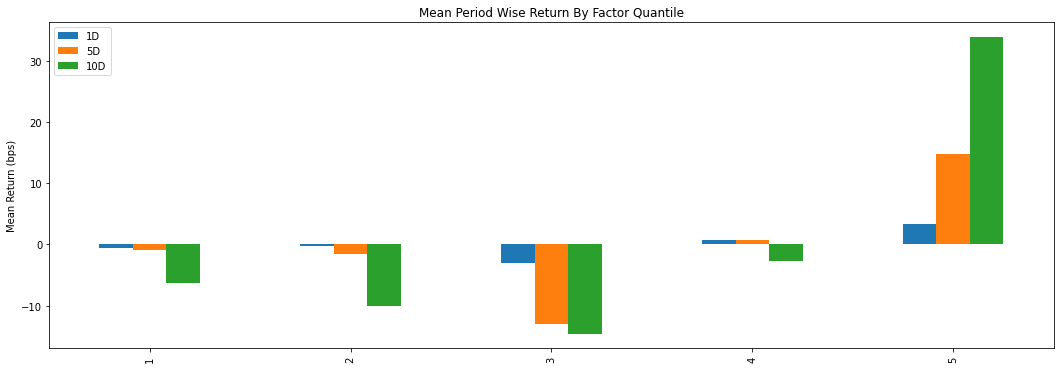

In [26]:
alphalens.plotting.plot_quantile_returns_bar(mean_return_by_q)

<AxesSubplot:title={'center':'Period Wise Return By Factor Quantile'}, ylabel='Return (bps)'>

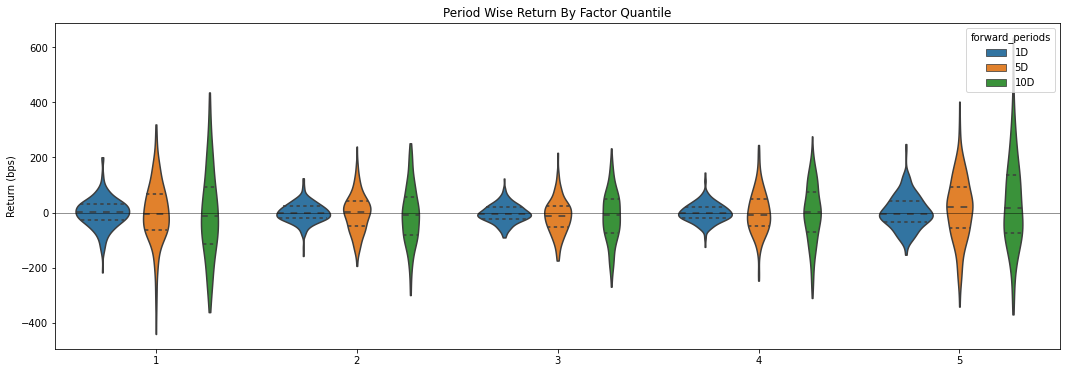

In [27]:
alphalens.plotting.plot_quantile_returns_violin(mean_return_by_q_daily)

In [28]:
quant_return_spread, std_err_spread = alphalens.performance.compute_mean_returns_spread(mean_return_by_q_daily,
                                                                                        upper_quant=5,
                                                                                        lower_quant=1,
                                                                                        std_err=std_err)

[<AxesSubplot:title={'center':'Top Minus Bottom Quantile Mean Return (1D Period Forward Return)'}, ylabel='Difference In Quantile Mean Return (bps)'>,
 <AxesSubplot:title={'center':'Top Minus Bottom Quantile Mean Return (5D Period Forward Return)'}, ylabel='Difference In Quantile Mean Return (bps)'>,
 <AxesSubplot:title={'center':'Top Minus Bottom Quantile Mean Return (10D Period Forward Return)'}, ylabel='Difference In Quantile Mean Return (bps)'>]

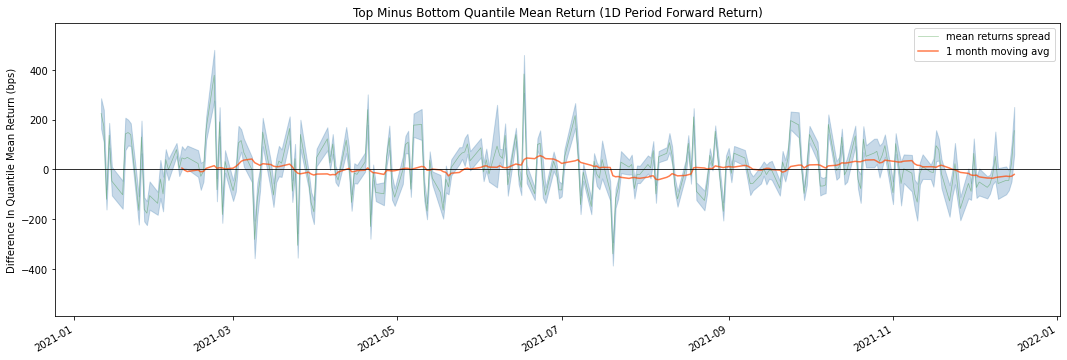

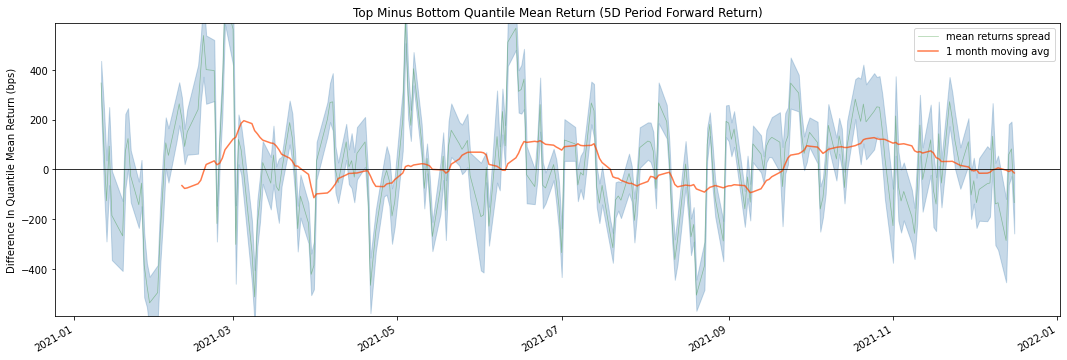

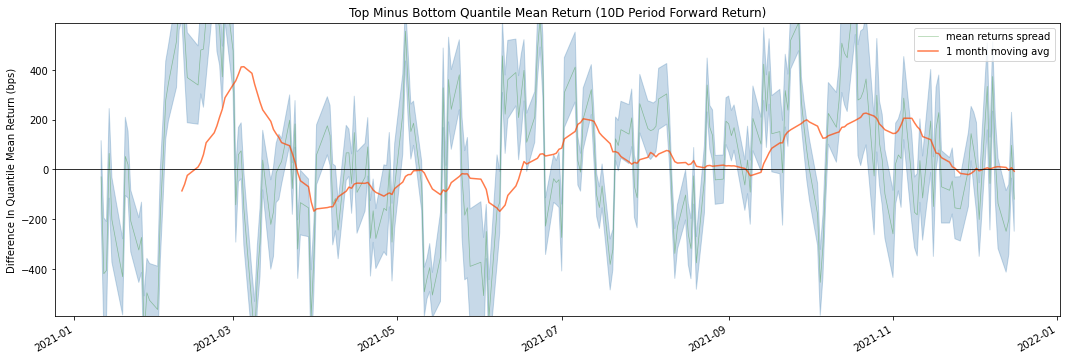

In [29]:
alphalens.plotting.plot_mean_quantile_returns_spread_time_series(quant_return_spread, std_err_spread)

<AxesSubplot:title={'center':'Cumulative Return by Quantile\n                    (1D Period Forward Return)'}, ylabel='Log Cumulative Returns'>

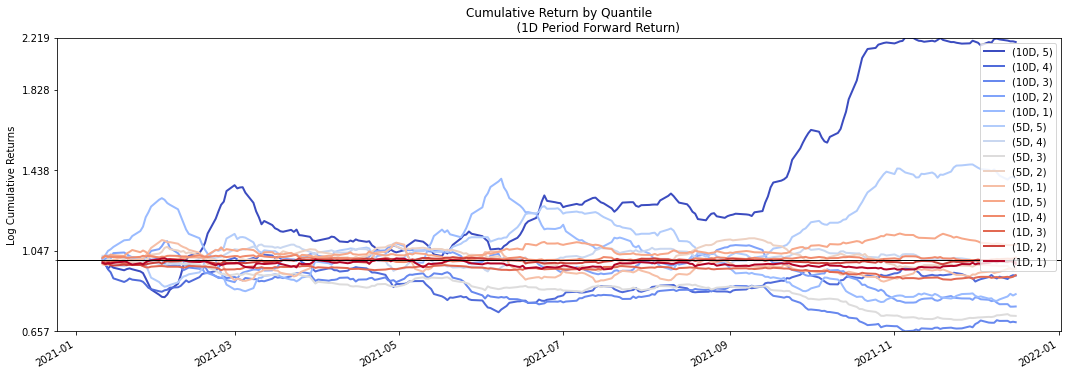

In [30]:
alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q_daily, period='1D')

In [31]:
ls_factor_returns = alphalens.performance.factor_returns(factor_data)

In [32]:
ls_factor_returns.head()

1D        5D       10D
date                                    
2021-01-11  0.011277  0.016286  0.001254
2021-01-12  0.008865  0.005863 -0.020824
2021-01-13 -0.006353 -0.003274 -0.020350
2021-01-14  0.008151  0.007827  0.007994
2021-01-15 -0.000456 -0.003915 -0.005342

<AxesSubplot:title={'center':'Portfolio Cumulative Return (1D Fwd Period)'}, ylabel='Cumulative Returns'>

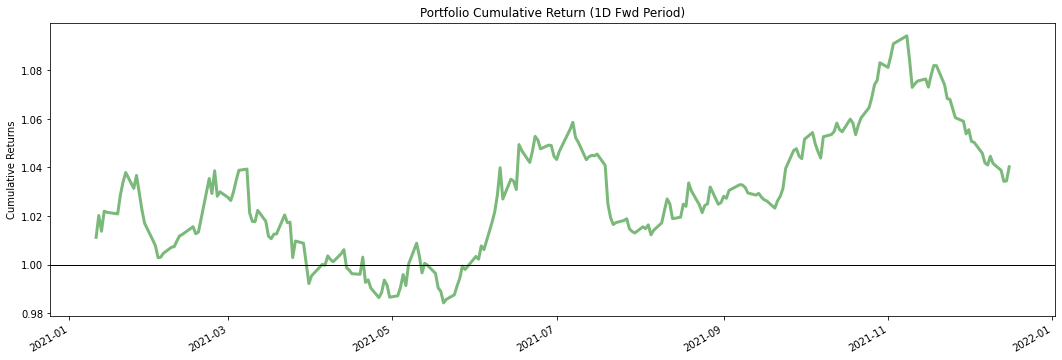

In [33]:
alphalens.plotting.plot_cumulative_returns(ls_factor_returns['1D'], period='1D')

<AxesSubplot:title={'center':'Portfolio Cumulative Return (5D Fwd Period)'}, ylabel='Cumulative Returns'>

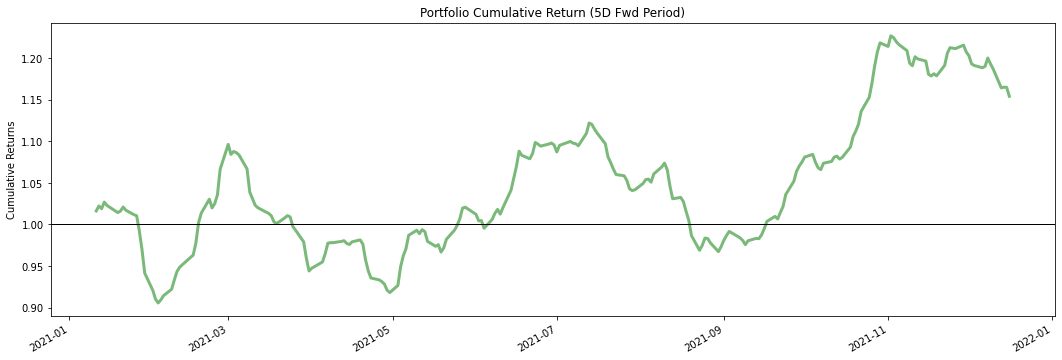

In [34]:
alphalens.plotting.plot_cumulative_returns(ls_factor_returns['5D'], period='5D')

<AxesSubplot:title={'center':'Portfolio Cumulative Return (10D Fwd Period)'}, ylabel='Cumulative Returns'>

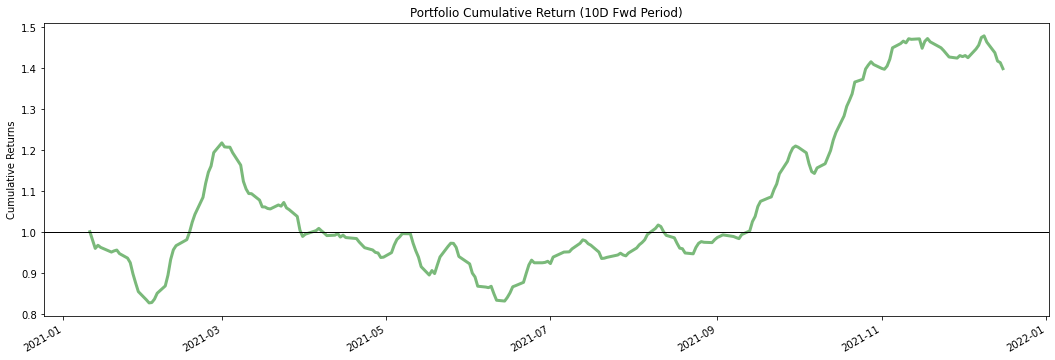

In [35]:
alphalens.plotting.plot_cumulative_returns(ls_factor_returns['10D'], period='10D')

In [36]:
alpha_beta = alphalens.performance.factor_alpha_beta(factor_data)
alpha_beta

1D        5D       10D
Ann. alpha  0.064815  0.072389  0.066327
beta       -0.082464 -0.186539 -0.125272

Returns Analysis


1D     5D    10D
Ann. alpha                                     0.065  0.072  0.066
beta                                          -0.082 -0.187 -0.125
Mean Period Wise Return Top Quantile (bps)     3.332  2.967  3.381
Mean Period Wise Return Bottom Quantile (bps) -0.572 -0.195 -0.626
Mean Period Wise Spread (bps)                  3.904  3.154  3.998

<Figure size 432x288 with 0 Axes>

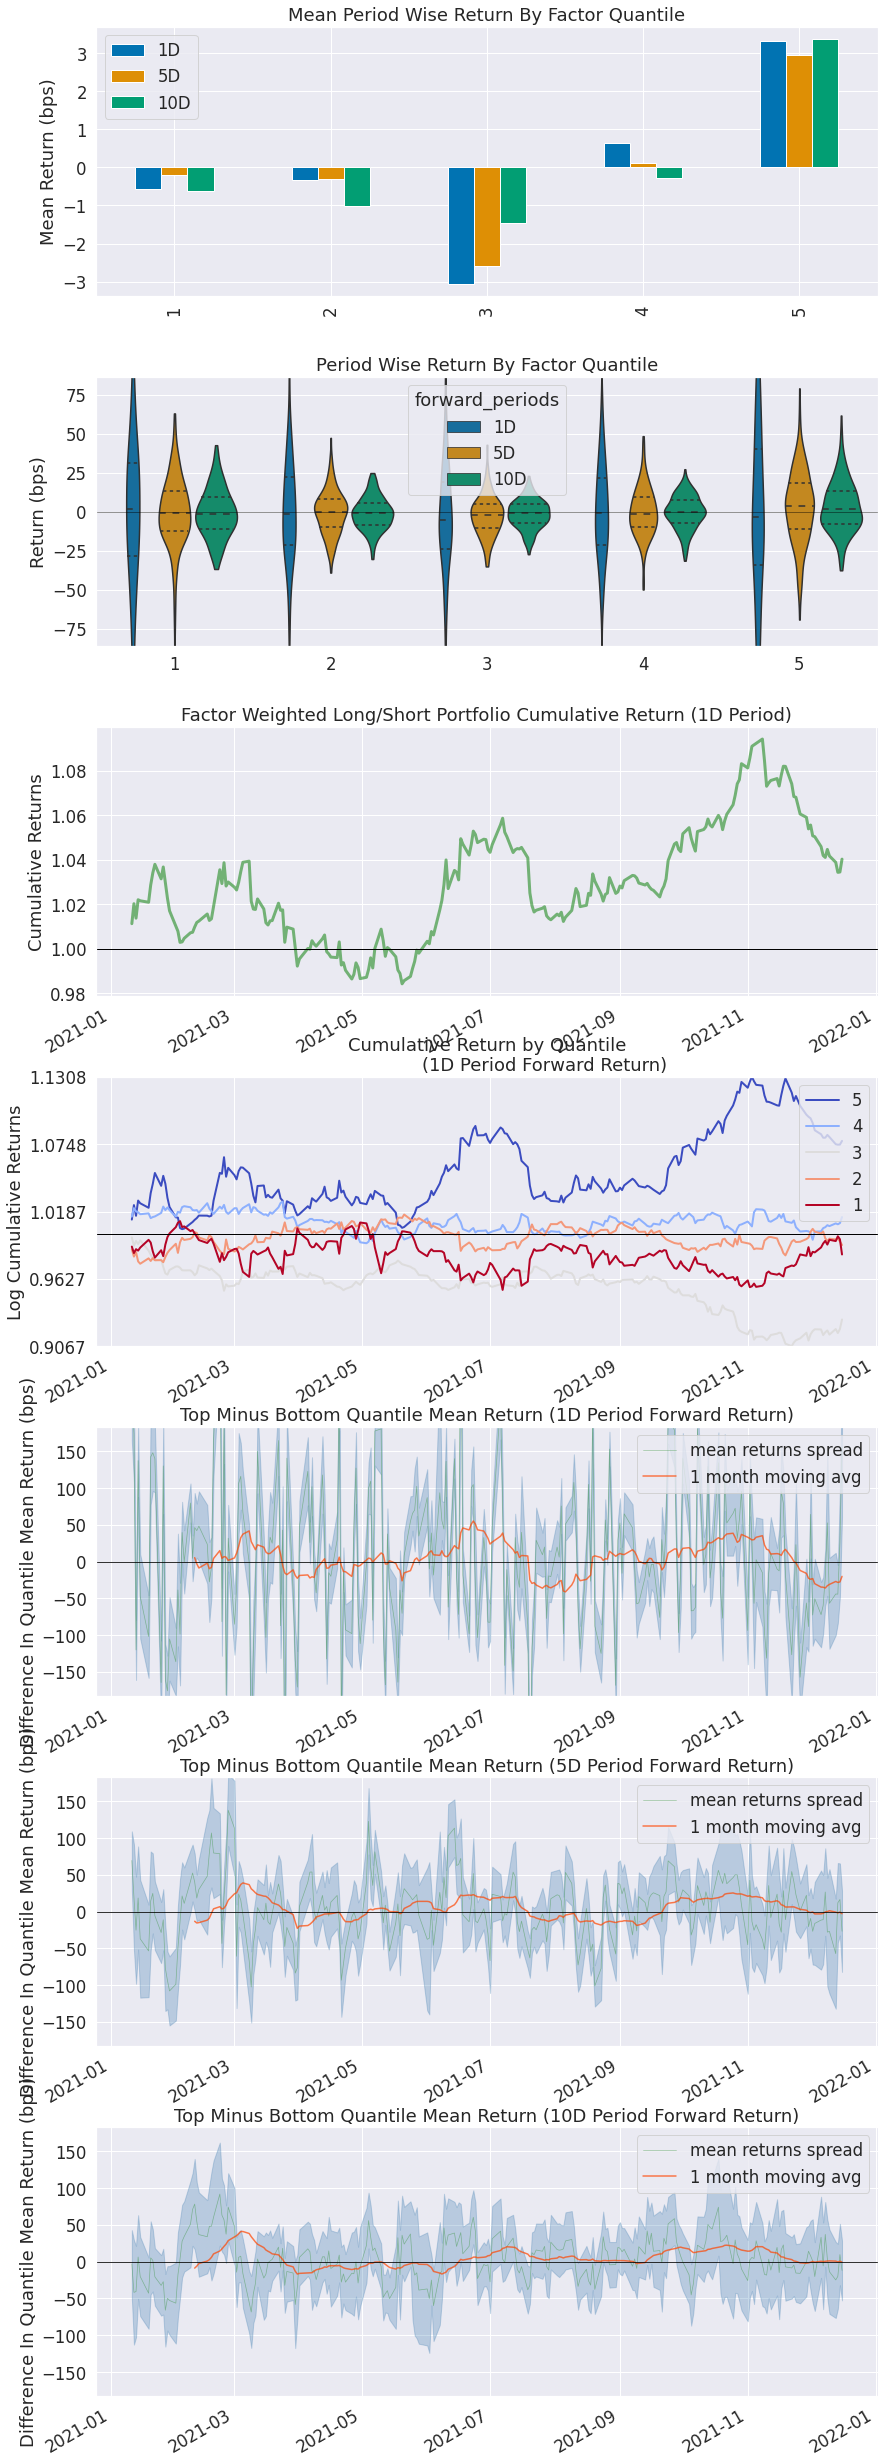

In [37]:
alphalens.tears.create_returns_tear_sheet(factor_data)

In [38]:
ic = alphalens.performance.factor_information_coefficient(factor_data)
ic.head()

1D        5D       10D
date                                    
2021-01-11  0.435713  0.398358  0.015003
2021-01-12  0.305824  0.076995 -0.380431
2021-01-13 -0.361200 -0.207012 -0.354502
2021-01-14  0.270844  0.008492  0.009726
2021-01-15 -0.109400 -0.237402 -0.248829

array([<AxesSubplot:title={'center':'1D Period Forward Return Information Coefficient (IC)'}, ylabel='IC'>,
       <AxesSubplot:title={'center':'5D Period Forward Return Information Coefficient (IC)'}, ylabel='IC'>,
       <AxesSubplot:title={'center':'10D Period Forward Return Information Coefficient (IC)'}, ylabel='IC'>],
      dtype=object)

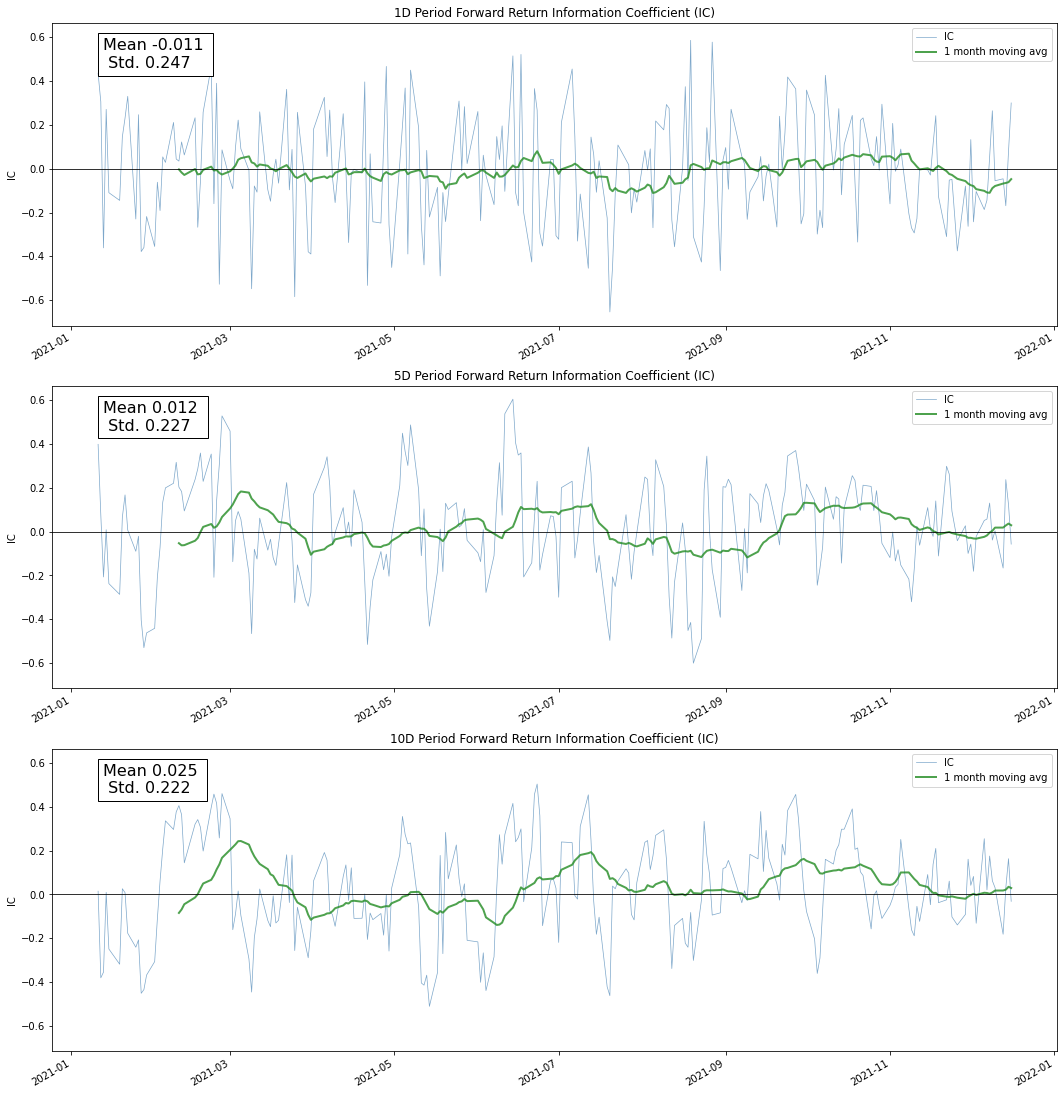

In [39]:
alphalens.plotting.plot_ic_ts(ic)

array([<AxesSubplot:title={'center':'1D Period IC'}, xlabel='IC', ylabel='Density'>,
       <AxesSubplot:title={'center':'5D Period IC'}, xlabel='IC', ylabel='Density'>,
       <AxesSubplot:title={'center':'10D Period IC'}, xlabel='IC', ylabel='Density'>],
      dtype=object)

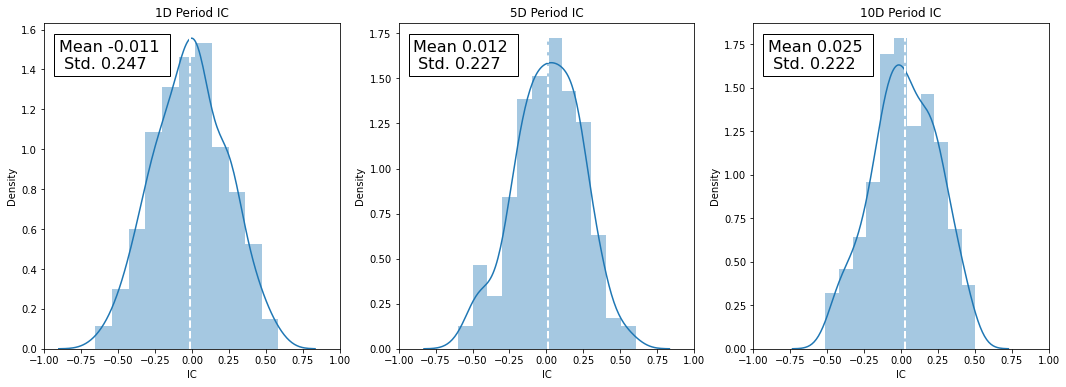

In [40]:
alphalens.plotting.plot_ic_hist(ic)

array([<AxesSubplot:title={'center':'1D Period IC Normal Dist. Q-Q'}, xlabel='Normal Distribution Quantile', ylabel='Observed Quantile'>,
       <AxesSubplot:title={'center':'5D Period IC Normal Dist. Q-Q'}, xlabel='Normal Distribution Quantile', ylabel='Observed Quantile'>,
       <AxesSubplot:title={'center':'10D Period IC Normal Dist. Q-Q'}, xlabel='Normal Distribution Quantile', ylabel='Observed Quantile'>],
      dtype=object)

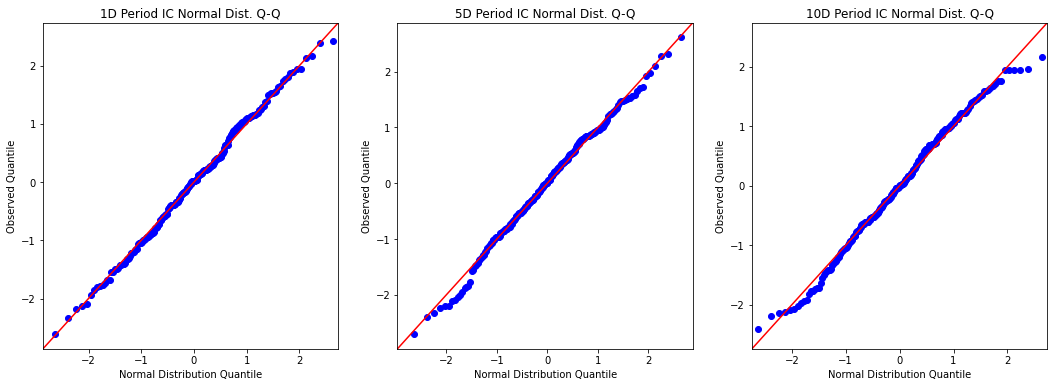

In [41]:
alphalens.plotting.plot_ic_qq(ic)

In [42]:
mean_monthly_ic = alphalens.performance.mean_information_coefficient(factor_data, by_time='M')
mean_monthly_ic.head()

1D        5D       10D
date                                    
2021-01-31  0.011845 -0.108163 -0.222853
2021-02-28  0.019707  0.150580  0.259685
2021-03-31 -0.057815 -0.081144 -0.095683
2021-04-30 -0.009155 -0.030689 -0.033884
2021-05-31 -0.010816  0.071427 -0.021902

array([<AxesSubplot:title={'center':'Monthly Mean 1D Period IC'}>,
       <AxesSubplot:title={'center':'Monthly Mean 5D Period IC'}>,
       <AxesSubplot:title={'center':'Monthly Mean 10D Period IC'}>],
      dtype=object)

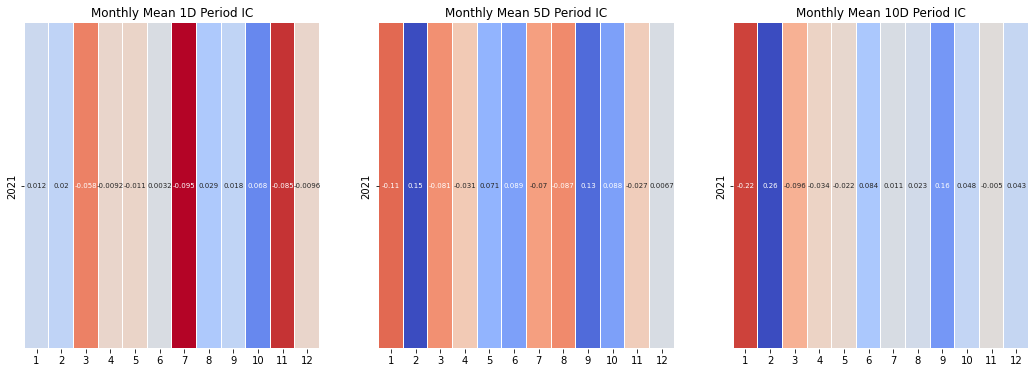

In [43]:
alphalens.plotting.plot_monthly_ic_heatmap(mean_monthly_ic)

Information Analysis


1D     5D    10D
IC Mean          -0.011  0.012  0.025
IC Std.           0.247  0.227  0.222
Risk-Adjusted IC -0.044  0.053  0.113
t-stat(IC)       -0.677  0.823  1.734
p-value(IC)       0.499  0.411  0.084
IC Skew          -0.012 -0.188 -0.133
IC Kurtosis      -0.418 -0.186 -0.566

<Figure size 432x288 with 0 Axes>

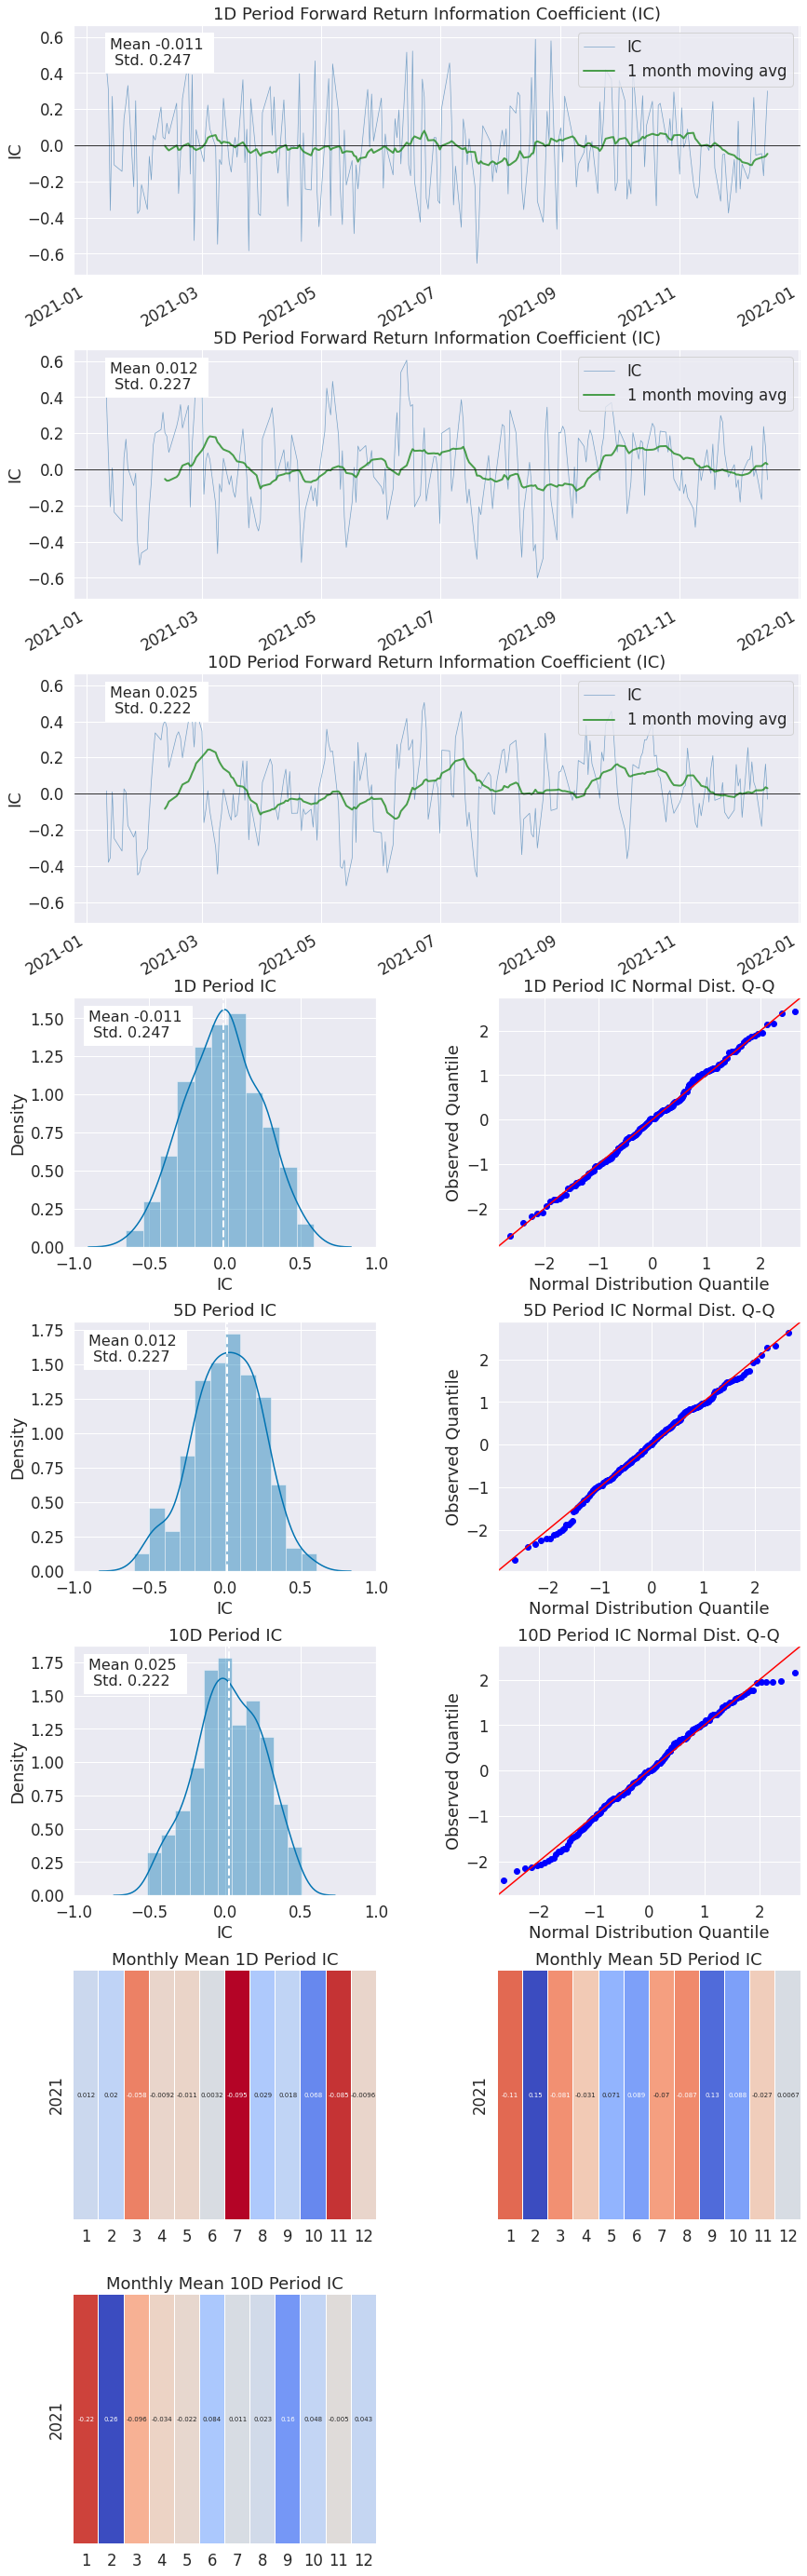

In [44]:
alphalens.tears.create_information_tear_sheet(factor_data)

In [45]:
quantile_factor = factor_data['factor_quantile']
turnover_period = 1

In [46]:
quantile_turnover = pd.concat([alphalens.performance.quantile_turnover(quantile_factor, q, turnover_period)
                               for q in range(1, int(quantile_factor.max()) + 1)], axis=1)

In [47]:
quantile_turnover.head()

1     2     3     4     5
date                                        
2021-01-11       NaN   NaN   NaN   NaN   NaN
2021-01-12  0.285714  0.65  0.60  0.45  0.30
2021-01-13  0.380952  0.65  0.65  0.50  0.25
2021-01-14  0.380952  0.70  0.75  0.40  0.30
2021-01-15  0.523810  0.70  0.75  0.55  0.30

<AxesSubplot:title={'center':'1D Period Top and Bottom Quantile Turnover'}, ylabel='Proportion Of Names New To Quantile'>

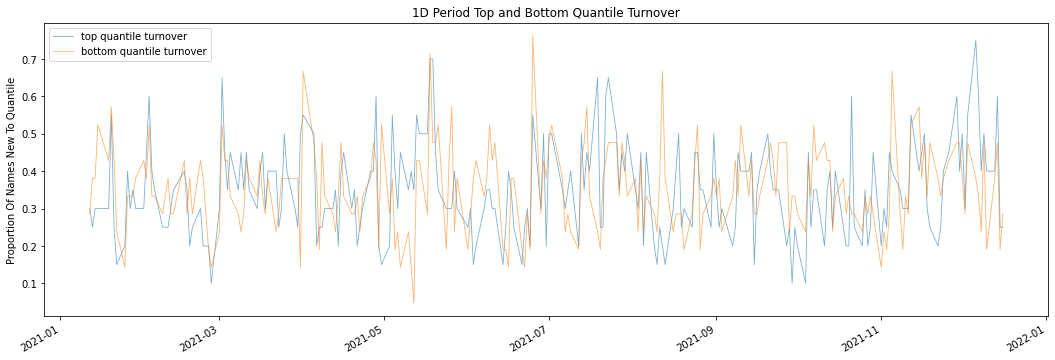

In [48]:
alphalens.plotting.plot_top_bottom_quantile_turnover(quantile_turnover, turnover_period)

In [49]:
factor_autocorrection = alphalens.performance.factor_rank_autocorrelation(factor_data, turnover_period)
factor_autocorrection.head()

date
2021-01-11         NaN
2021-01-12    0.908678
2021-01-13    0.901642
2021-01-14    0.773966
2021-01-15    0.737391
Name: 1, dtype: float64

<AxesSubplot:title={'center':'1D Period Factor Rank Autocorrelation'}, ylabel='Autocorrelation Coefficient'>

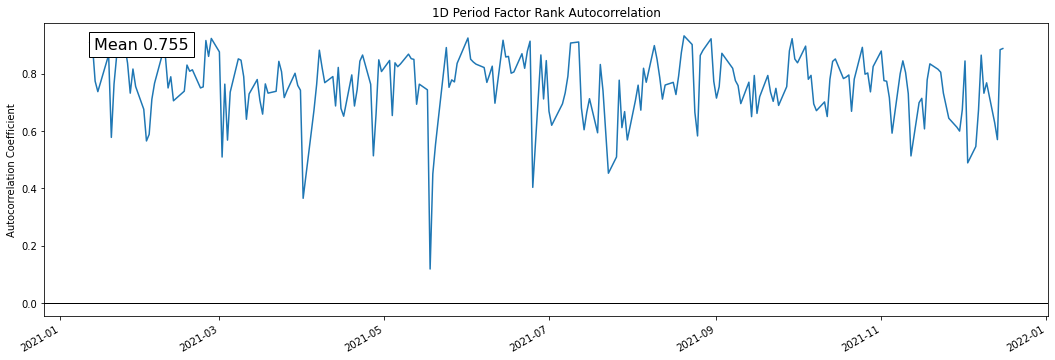

In [50]:
alphalens.plotting.plot_factor_rank_auto_correlation(factor_autocorrection)

Turnover Analysis


1D     5D    10D
Quantile 1 Mean Turnover   0.352  0.781  0.772
Quantile 2 Mean Turnover   0.625  0.799  0.790
Quantile 3 Mean Turnover   0.661  0.790  0.786
Quantile 4 Mean Turnover   0.611  0.796  0.798
Quantile 5 Mean Turnover   0.348  0.762  0.771

1D     5D    10D
Mean Factor Rank Autocorrelation  0.755  0.012  0.019

<Figure size 432x288 with 0 Axes>

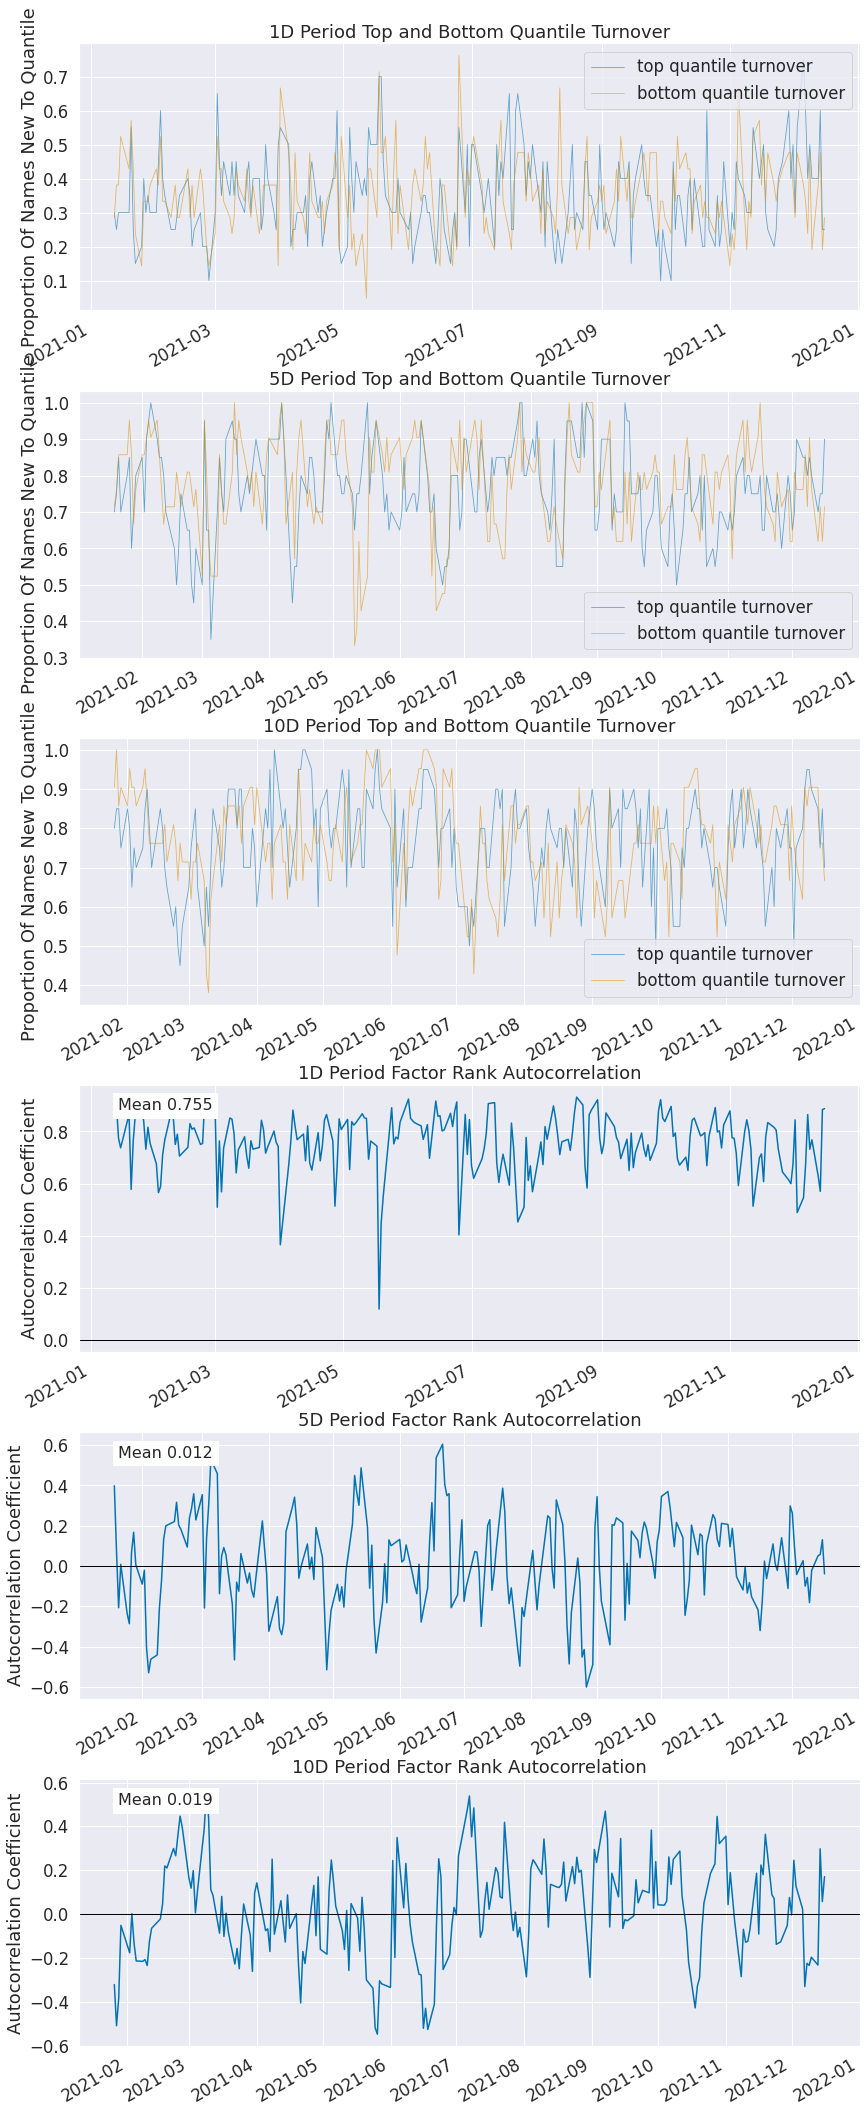

In [12]:
alphalens.tears.create_turnover_tear_sheet(factor_data)

<Figure size 432x288 with 0 Axes>

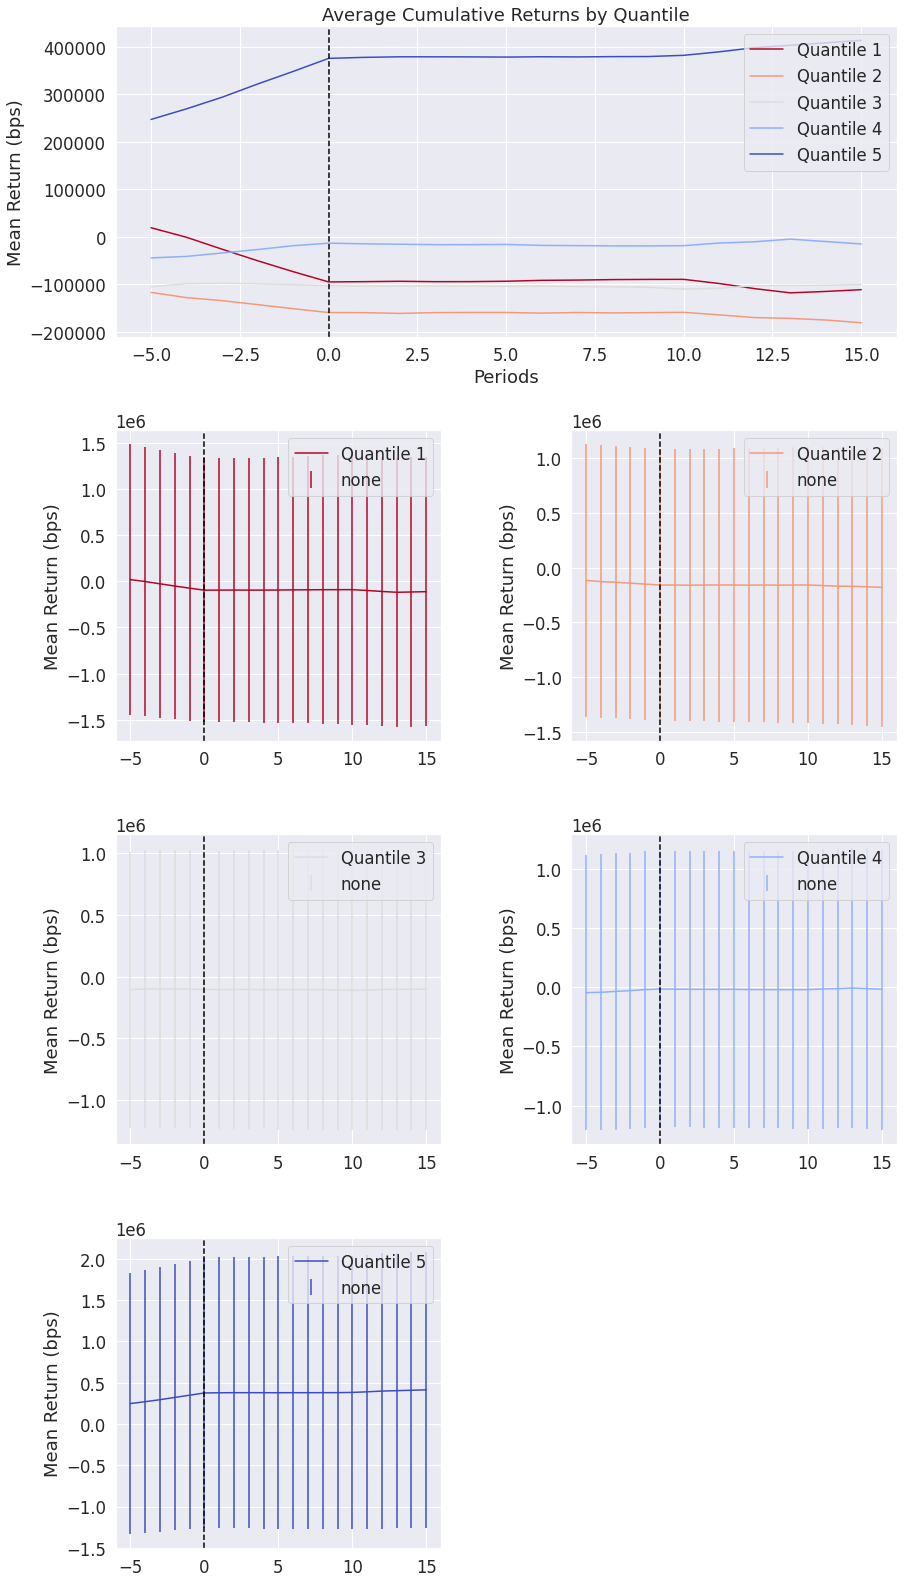

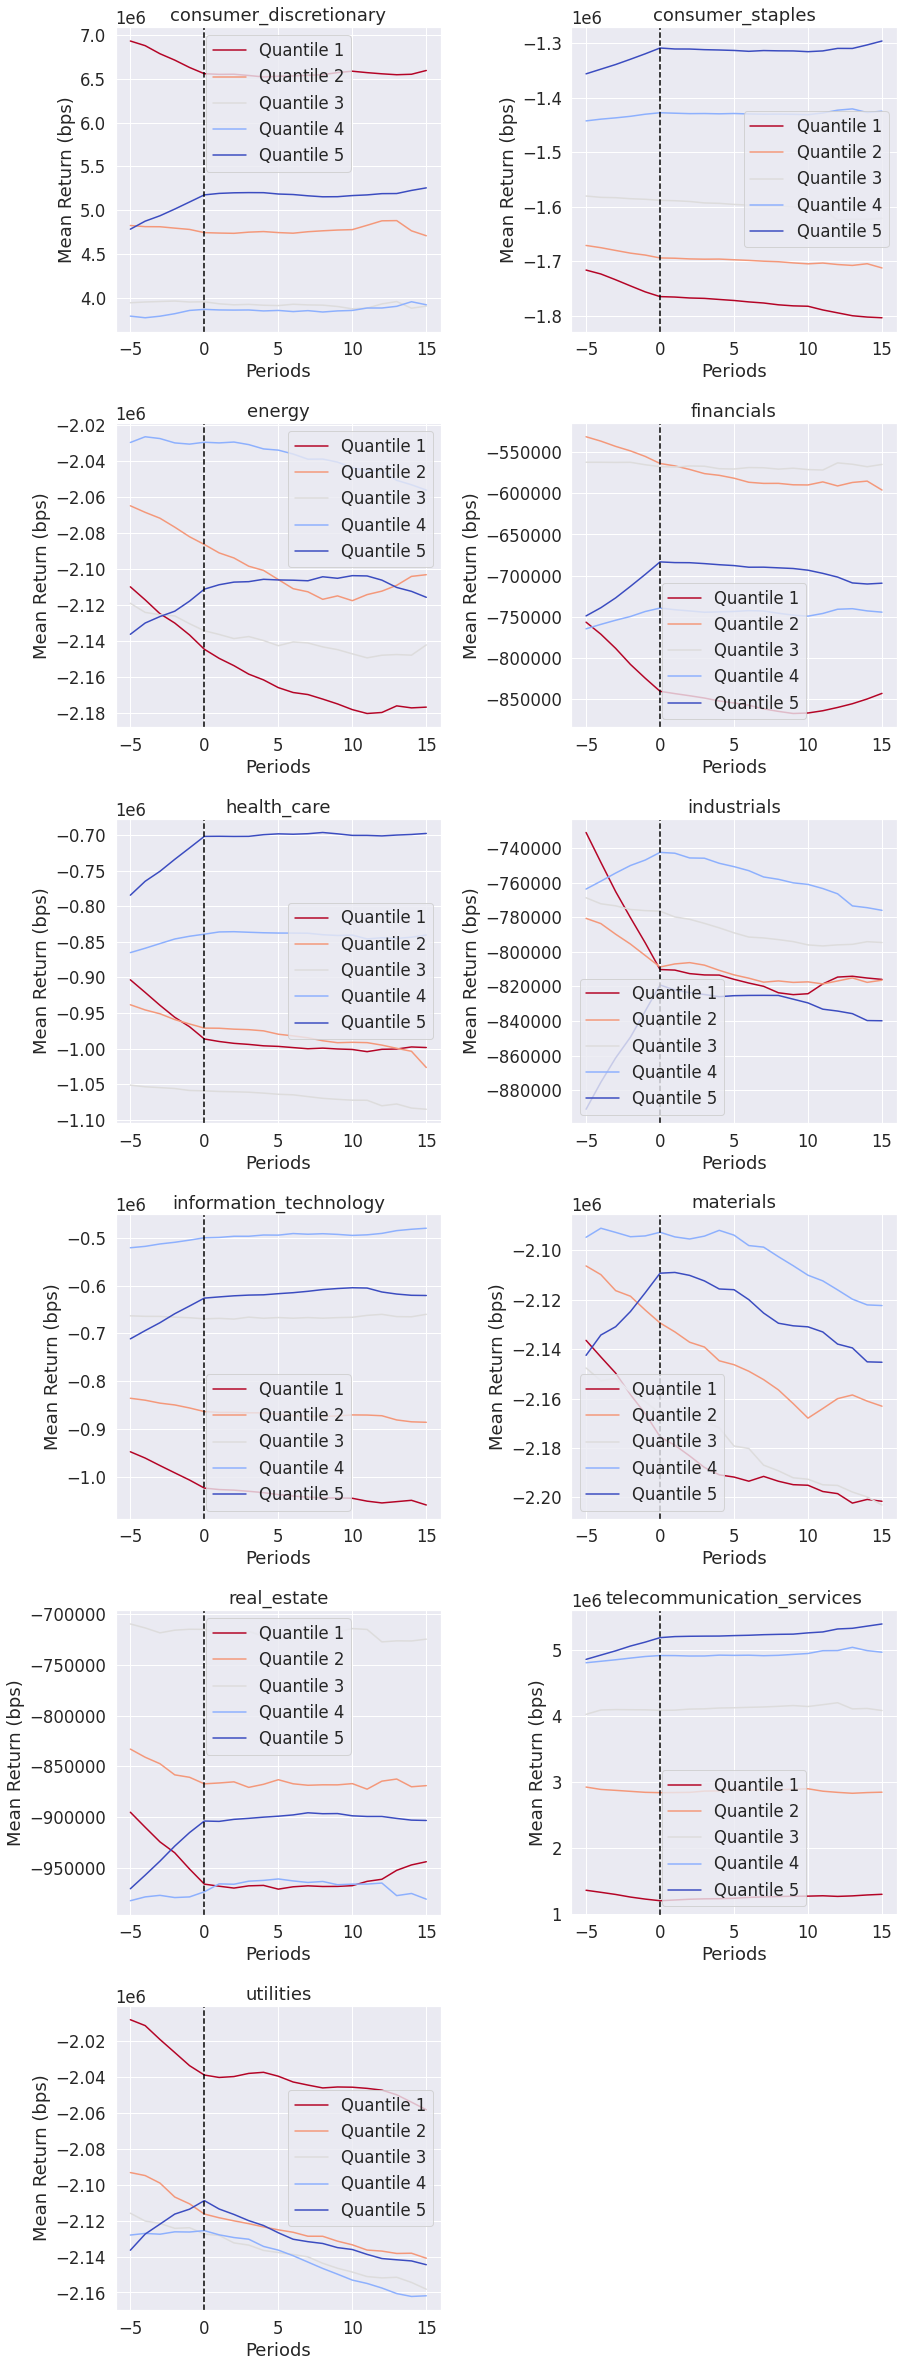

In [13]:
alphalens.tears.create_event_returns_tear_sheet(factor_data, pricing, by_group=True)

In [14]:
ic_by_sector = alphalens.performance.mean_information_coefficient(factor_data, by_group=True)

In [15]:
ic_by_sector.head()

1D        5D       10D
group                                               
consumer_discretionary  0.001509  0.056898  0.021762
consumer_staples       -0.024537  0.003658  0.056791
energy                  0.010549  0.118143  0.166667
financials             -0.004126  0.000869  0.016785
health_care             0.036014  0.027245  0.021037

<AxesSubplot:title={'center':'Information Coefficient By Group'}>

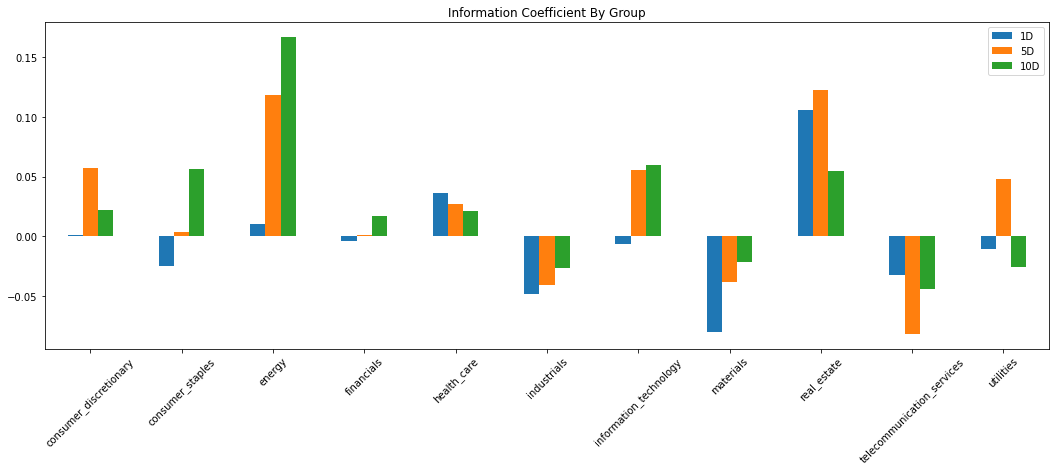

In [16]:
alphalens.plotting.plot_ic_by_group(ic_by_sector)

In [17]:
mean_return_quantile_sector, mean_return_quantile_sector_err = alphalens.performance.mean_return_by_quantile(factor_data, by_group=True)

In [18]:
mean_return_quantile_sector.head()

1D        5D       10D
factor_quantile group                                               
1               consumer_discretionary  0.000309 -0.002314 -0.002033
                consumer_staples       -0.000535 -0.001156 -0.005541
                energy                 -0.001237 -0.004650 -0.001421
                financials             -0.000518 -0.003934 -0.007019
                health_care            -0.001226 -0.002546 -0.003733

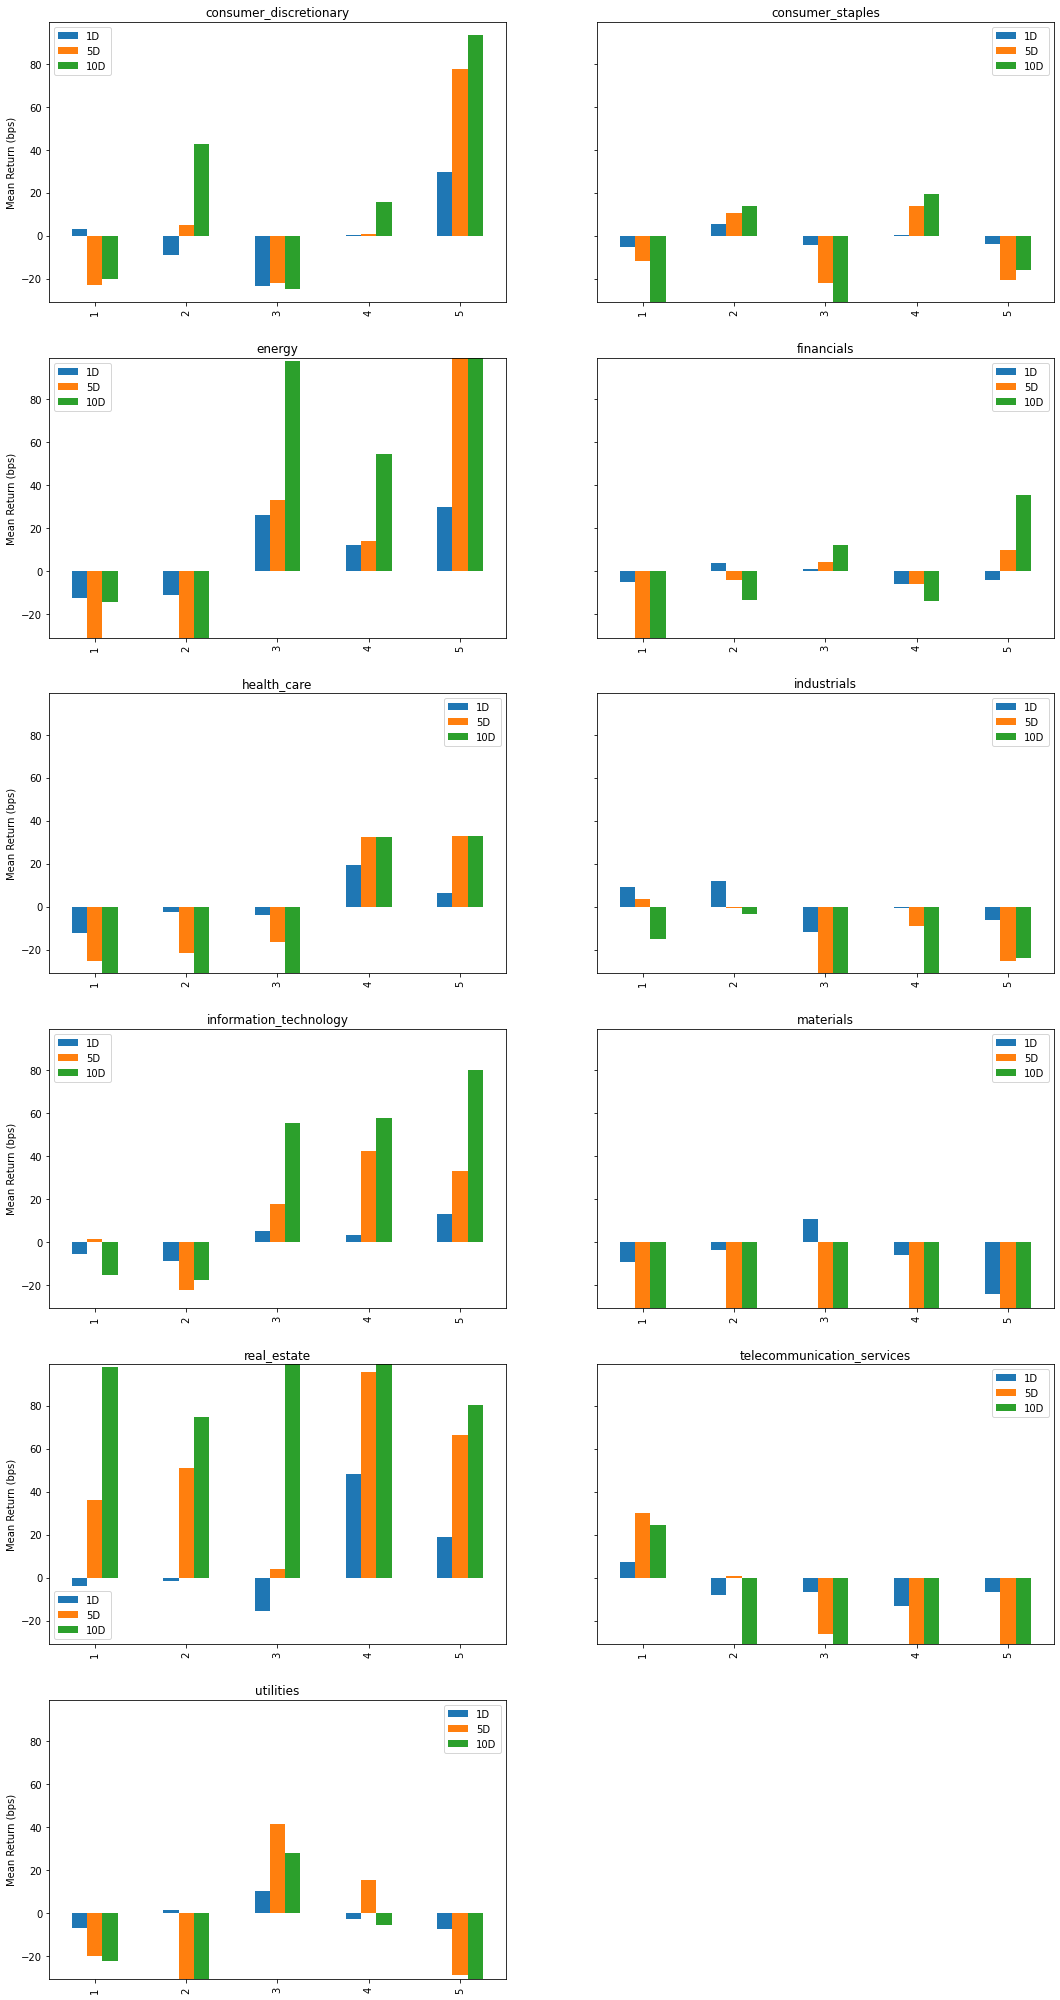

In [19]:
alphalens.plotting.plot_quantile_returns_bar(mean_return_quantile_sector, by_group=True);

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -0.190550  0.015460 -0.035367  0.024696   4977  20.792079
2               -0.067036  0.032034 -0.009386  0.014812   4740  19.801980
3               -0.049547  0.051635  0.004079  0.014319   4740  19.801980
4               -0.030926  0.095678  0.017968  0.015691   4740  19.801980
5               -0.012942  0.544042  0.047094  0.032760   4740  19.801980

Returns Analysis


1D     5D    10D
Ann. alpha                                     0.065  0.072  0.066
beta                                          -0.082 -0.187 -0.125
Mean Period Wise Return Top Quantile (bps)     3.332  2.967  3.381
Mean Period Wise Return Bottom Quantile (bps) -0.572 -0.195 -0.626
Mean Period Wise Spread (bps)                  3.904  3.154  3.998

Information Analysis


1D     5D    10D
IC Mean          -0.011  0.012  0.025
IC Std.           0.247  0.227  0.222
Risk-Adjusted IC -0.044  0.053  0.113
t-stat(IC)       -0.677  0.823  1.734
p-value(IC)       0.499  0.411  0.084
IC Skew          -0.012 -0.188 -0.133
IC Kurtosis      -0.418 -0.186 -0.566

Turnover Analysis


1D     5D    10D
Quantile 1 Mean Turnover   0.352  0.781  0.772
Quantile 2 Mean Turnover   0.625  0.799  0.790
Quantile 3 Mean Turnover   0.661  0.790  0.786
Quantile 4 Mean Turnover   0.611  0.796  0.798
Quantile 5 Mean Turnover   0.348  0.762  0.771

1D     5D    10D
Mean Factor Rank Autocorrelation  0.755  0.012  0.019

<Figure size 432x288 with 0 Axes>

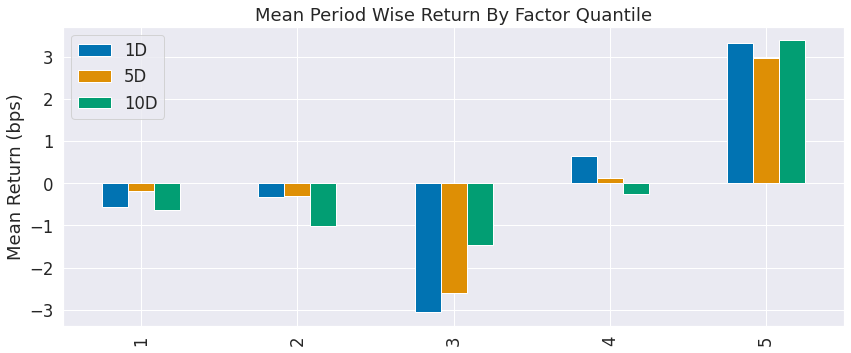

In [20]:
alphalens.tears.create_summary_tear_sheet(factor_data)

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -0.190550  0.015460 -0.035367  0.024696   4977  20.792079
2               -0.067036  0.032034 -0.009386  0.014812   4740  19.801980
3               -0.049547  0.051635  0.004079  0.014319   4740  19.801980
4               -0.030926  0.095678  0.017968  0.015691   4740  19.801980
5               -0.012942  0.544042  0.047094  0.032760   4740  19.801980

Returns Analysis


1D     5D    10D
Ann. alpha                                     0.065  0.072  0.066
beta                                          -0.082 -0.187 -0.125
Mean Period Wise Return Top Quantile (bps)     3.332  2.967  3.381
Mean Period Wise Return Bottom Quantile (bps) -0.572 -0.195 -0.626
Mean Period Wise Spread (bps)                  3.904  3.154  3.998

<Figure size 432x288 with 0 Axes>

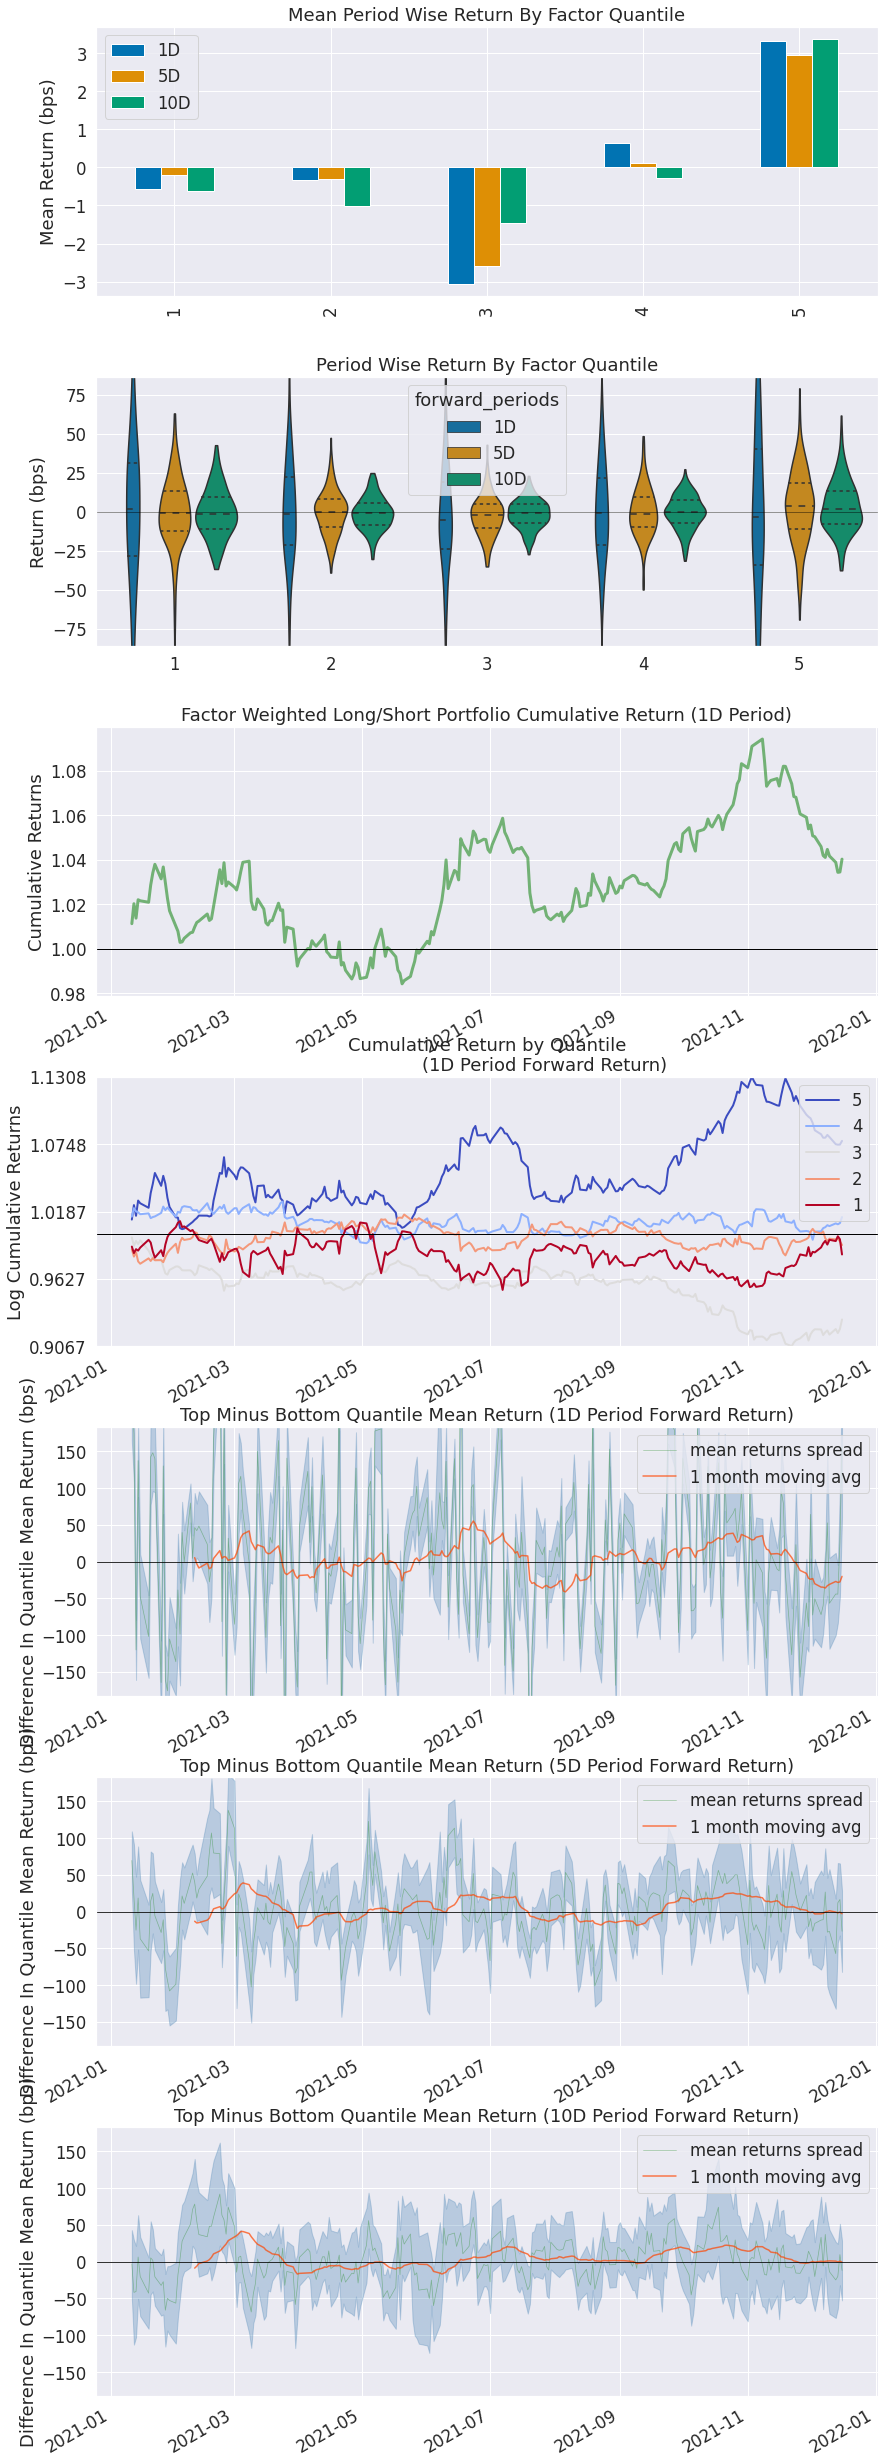

Information Analysis


1D     5D    10D
IC Mean          -0.011  0.012  0.025
IC Std.           0.247  0.227  0.222
Risk-Adjusted IC -0.044  0.053  0.113
t-stat(IC)       -0.677  0.823  1.734
p-value(IC)       0.499  0.411  0.084
IC Skew          -0.012 -0.188 -0.133
IC Kurtosis      -0.418 -0.186 -0.566

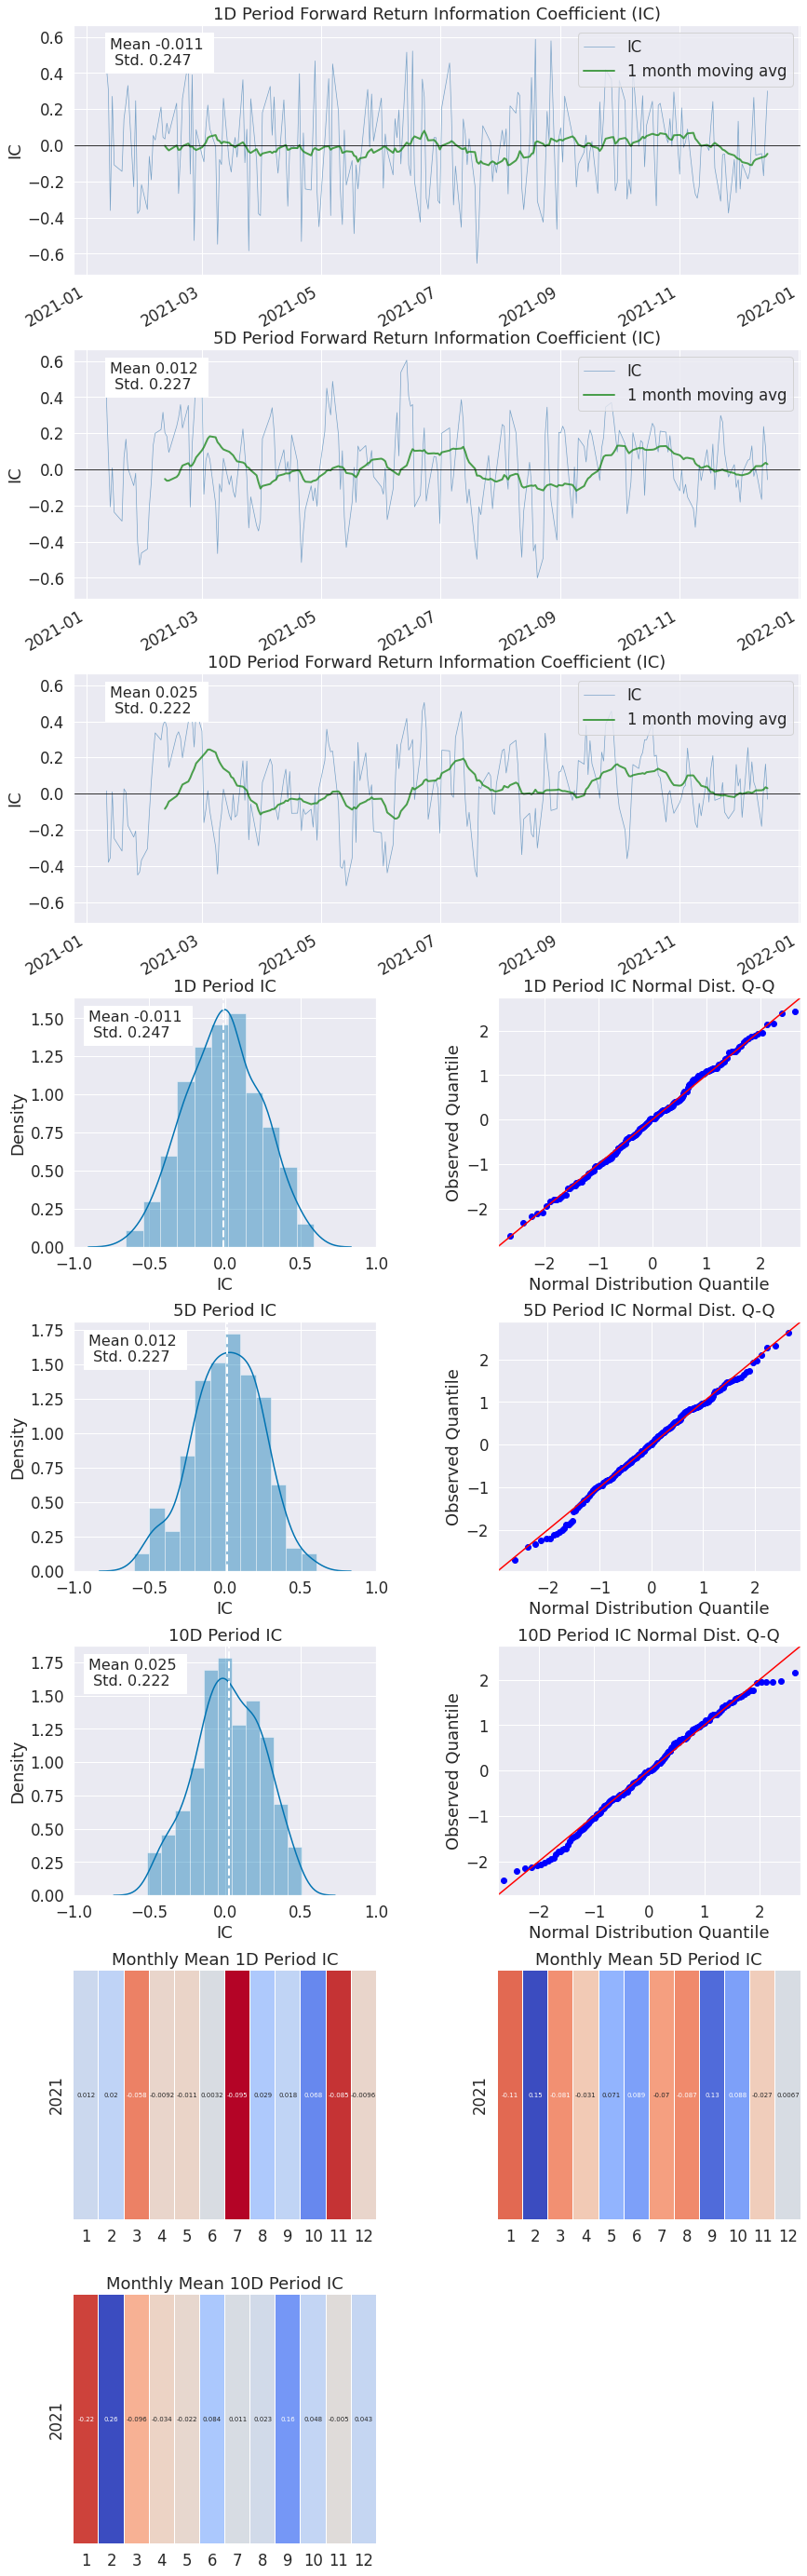

Turnover Analysis


1D     5D    10D
Quantile 1 Mean Turnover   0.352  0.781  0.772
Quantile 2 Mean Turnover   0.625  0.799  0.790
Quantile 3 Mean Turnover   0.661  0.790  0.786
Quantile 4 Mean Turnover   0.611  0.796  0.798
Quantile 5 Mean Turnover   0.348  0.762  0.771

1D     5D    10D
Mean Factor Rank Autocorrelation  0.755  0.012  0.019

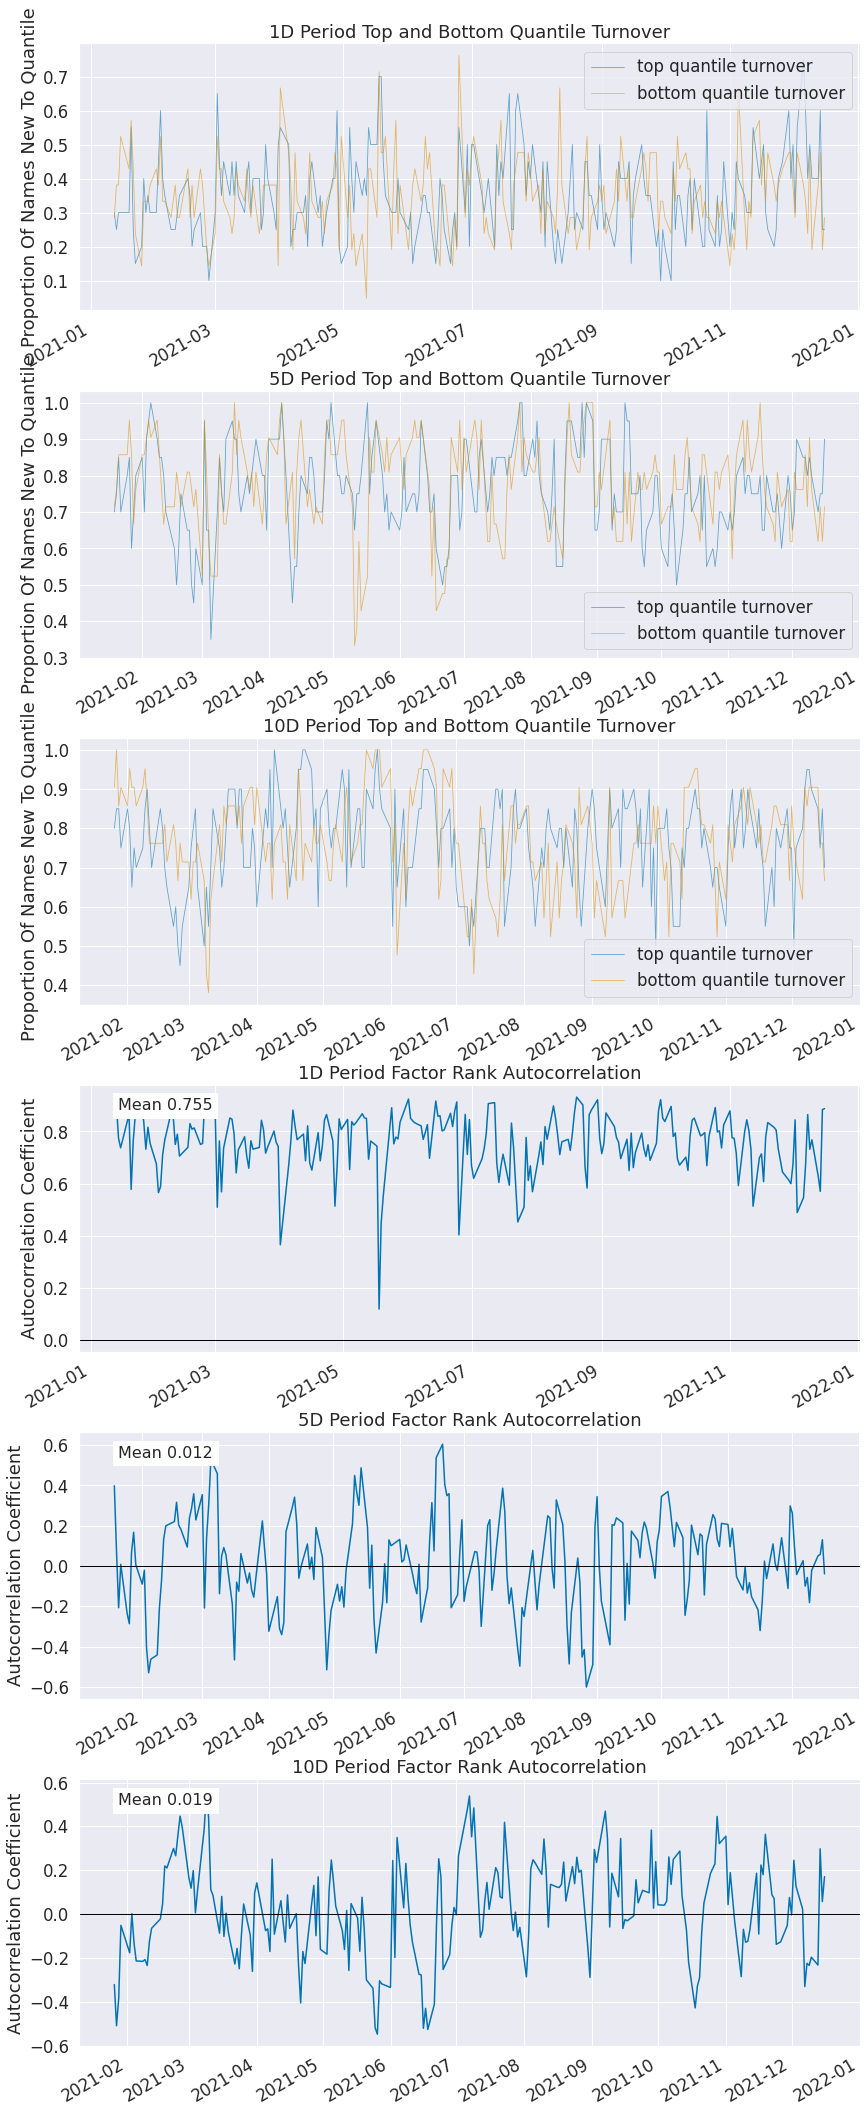

In [21]:
alphalens.tears.create_full_tear_sheet(factor_data)

In [ ]:
df = web.DataReader(['GE', 'BRK-B'], 'yahoo', start='2019-09-10', end='2019-10-09')
df